 #**05. Model Training & Evaluation**

### Business Context

Our telecom client loses approximately \$70 per month for each customer who churns, or around \$175,000 per month in revenue
**Goal:** Build a model that flags likely churners with **≥60% recall** while keeping false positives low enough to make targeted retention campaigns cost-effective.


In this notebook, we pick up exactly where we left off in Notebook 04, with our cleaned, encoded, and scaled features split into training, validation, and test sets. Our goal here is to turn those data splits into a robust churn prediction model.

**Objectives:**
1. **Load** the preprocessed train/validation/test data (`X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`).  
2. **Train** baseline classifiers (e.g., Logistic Regression, Random Forest) on the training set.  
3. **Evaluate** each model on the validation set using accuracy, precision, recall, F1-score, and confusion matrices.  
4. **Tune** hyperparameters based on validation performance (e.g., via GridSearchCV or manual tweaking).  
5. **Select** the best model and **test** it on the hold-out test set for a final, unbiased performance report.  
6. **Save** the final model for deployment or future use.

Everything we’ve meticulously built—binary encoding, one-hot encoding, scaling, and data splits—is already in place.   


In [2]:
import pandas as pd

# Load feature sets
X_train = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Customer-churn-prediction\data/X_train.csv")
X_val = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Customer-churn-prediction\data/X_val.csv")
X_test = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Customer-churn-prediction\data/X_test.csv")

# Load target variables
y_train = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Customer-churn-prediction\data/y_train.csv")["Churn"]
y_val = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Customer-churn-prediction\data/y_val.csv")["Churn"]
y_test = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Customer-churn-prediction\data/y_test.csv")["Churn"]

# Confirm shapes
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (4922, 23) y_train: (4922,)
X_val  : (1055, 23) y_val  : (1055,)
X_test : (1055, 23) y_test : (1055,)


##  Establishing a Baseline Model

## 05.2 Establishing a Baseline Model

Before jumping into powerful machine learning algorithms, it's important to create a baseline. This gives us a reference point to understand whether our actual models are performing well or just doing random guessing.

We’ll use `DummyClassifier` from `sklearn`, which is a simple rule-based model. 

**Our strategy:**  
We'll use `strategy="most_frequent"` meaning it will always guess the most common class in `y_train`.

This helps us understand:
- How imbalanced our data might be.
- What kind of accuracy we get without learning anything.


In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Build and fit baseline model
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# 2. Predict on validation set
y_val_preds = dummy_clf.predict(X_val)

# 3. Evaluate baseline performance
baseline_accuracy  = accuracy_score(y_val, y_val_preds)
baseline_precision = precision_score(y_val, y_val_preds, zero_division=0)
baseline_recall    = recall_score(y_val, y_val_preds)
baseline_f1        = f1_score(y_val, y_val_preds)

print("Baseline Performance (Most Frequent Strategy):")
print(f"Accuracy : {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall   : {baseline_recall:.4f}")
print(f"F1 Score : {baseline_f1:.4f}")


Baseline Performance (Most Frequent Strategy):
Accuracy : 0.7336
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000


### Logistic Regression

We'll start with a simple Logistic Regression model as our baseline. It's fast, interpretable, and often performs surprisingly well on binary classification tasks like this.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and fit the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val)

# Evaluate
print(classification_report(y_val, y_val_pred, target_names=["No Churn", "Churn"]))


              precision    recall  f1-score   support

    No Churn       0.86      0.90      0.88       774
       Churn       0.69      0.60      0.65       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.76      1055
weighted avg       0.82      0.82      0.82      1055



The Logistic Regression model gave a solid accuracy of 82%, which already outperforms the baseline.
However, we see some imbalance in how well it detects churn vs. non-churn:

No Churn: Precision = 0.86, Recall = 0.90 — very strong.

Churn: Precision = 0.69, Recall = 0.60 — weaker recall means we're still missing a good chunk of actual churners.

We’re on the right track, but there’s room to improve recall for churn.

## Further Evaluation & Tuning of Logistic Regression

Before moving on, we’ll dive deeper into our Logistic Regression:

1. **Compute ROC AUC** on the validation set to get a sense of overall discrimination power.  
2. **Plot the ROC curve** to visualize tradeoffs.  
3. **Examine the confusion matrix** to see exactly where misclassifications are happening.  
4. **Introduce class weighting** (`class_weight="balanced"`) and do a quick GridSearchCV over the regularization strength (`C`) to improve recall for the minority class (Churn).


Logistic ROC AUC: 0.8534


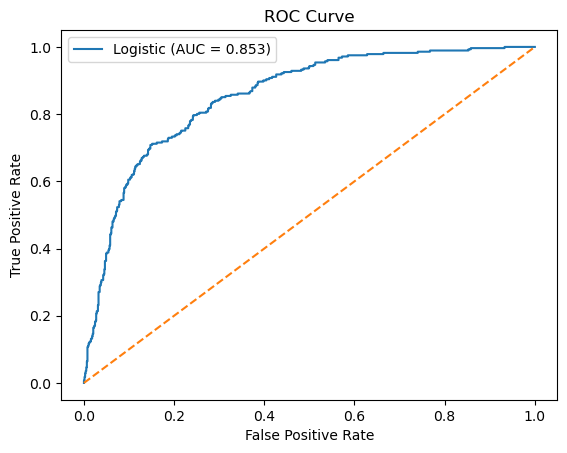

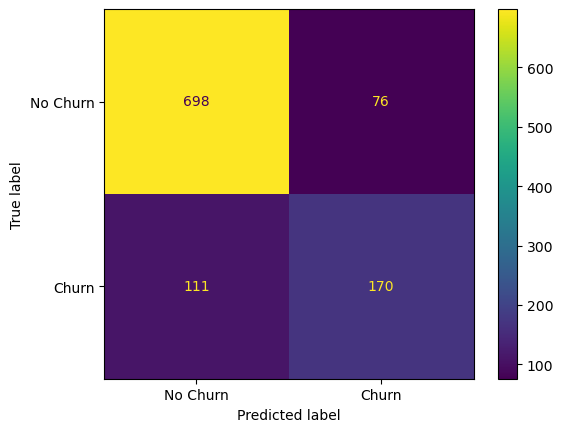

Best params: {'C': 1, 'class_weight': 'balanced'}
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.81       774
       Churn       0.52      0.81      0.63       281

    accuracy                           0.75      1055
   macro avg       0.71      0.77      0.72      1055
weighted avg       0.81      0.75      0.76      1055



In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# 1. Baseline ROC AUC and Curve
y_val_probs = log_reg.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_probs)
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)

print(f"Logistic ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')  # random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 2. Confusion Matrix at default threshold=0.5
ConfusionMatrixDisplay.from_estimator(log_reg, X_val, y_val, display_labels=["No Churn","Churn"])
plt.show()

# 3. Quick hyperparameter tuning with class weights
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None]
}
grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                    param_grid, cv=5, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_log = grid.best_estimator_

# 4. Evaluate tuned model on validation
y_val_pred_tuned = best_log.predict(X_val)
print(classification_report(y_val, y_val_pred_tuned, target_names=["No Churn","Churn"]))


## 05.4 Adjusting Decision Threshold for Logistic Regression

Instead of using the default 0.5 probability cut-off, we’ll:

1. Compute precision, recall for a range of thresholds.  
2. Choose the threshold that achieves our target recall (e.g., ≥ 0.75) with decent precision.  
3. Apply that threshold and re-evaluate metrics and confusion matrix.


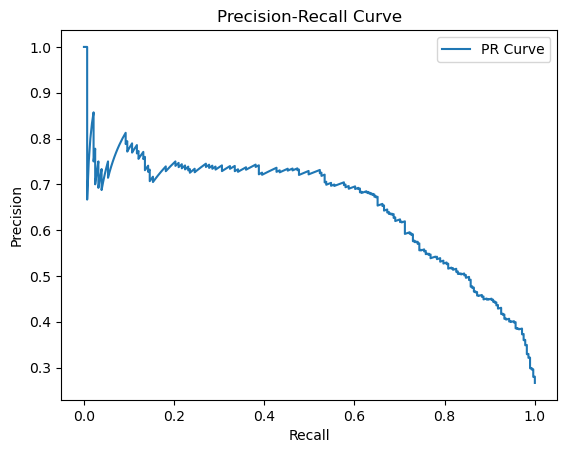

Chosen threshold: 0.580 → Precision: 0.558, Recall: 0.754
              precision    recall  f1-score   support

    No Churn       0.90      0.78      0.84       774
       Churn       0.56      0.75      0.64       281

    accuracy                           0.78      1055
   macro avg       0.73      0.77      0.74      1055
weighted avg       0.81      0.78      0.78      1055



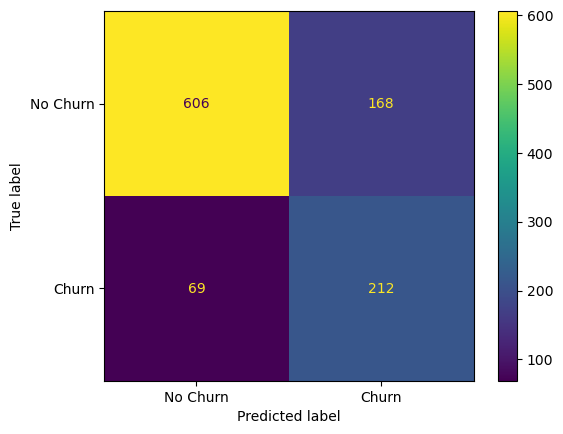

In [6]:
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Get probabilities from the tuned model
probs = best_log.predict_proba(X_val)[:, 1]

# 2. Compute precision-recall curve
precisions, recalls, thresh = precision_recall_curve(y_val, probs)

# 3. Plot PR curve
plt.figure()
plt.plot(recalls, precisions, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 4. Find threshold for recall ≥ 0.75
target_recall = 0.75
# pick the highest precision among thresholds that achieve recall ≥ target_recall
valid = [(t, p, r) for p, r, t in zip(precisions, recalls, thresh) if r >= target_recall]
best_thresh, best_prec, best_rec = max(valid, key=lambda x: x[1])
print(f"Chosen threshold: {best_thresh:.3f} → Precision: {best_prec:.3f}, Recall: {best_rec:.3f}")

# 5. Apply threshold and evaluate
y_thresh_pred = (probs >= best_thresh).astype(int)
print(classification_report(y_val, y_thresh_pred, target_names=["No Churn","Churn"]))
ConfusionMatrixDisplay.from_predictions(y_val, y_thresh_pred, display_labels=["No Churn","Churn"])
plt.show()


_We moved to Random Forest because tree-based models can capture non-linear interactions and complex feature interactions that a linear model like Logistic Regression might miss._


## Baseline Random Forest


Now we’ll train a basic Random Forest classifier to see if a tree‐based model can outperform our tuned Logistic Regression in terms of recall and overall balance.

1. Initialize `RandomForestClassifier` with a fixed `random_state`.  
2. Fit on `X_train`, `y_train`.  
3. Predict on `X_val`.  
4. Print classification report and plot confusion matrix.


Random Forest Validation Performance:

              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.87       774
       Churn       0.65      0.49      0.56       281

    accuracy                           0.79      1055
   macro avg       0.74      0.70      0.71      1055
weighted avg       0.78      0.79      0.78      1055



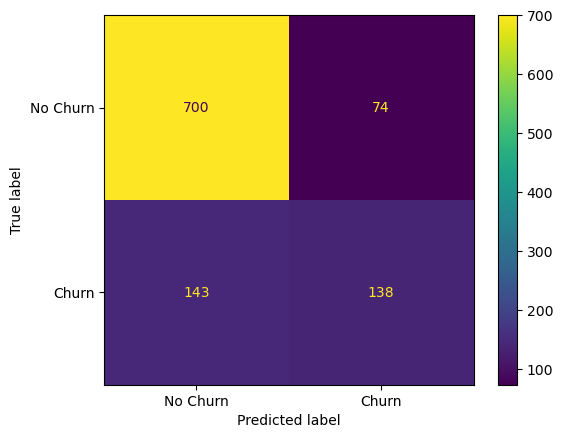

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Initialize & fit
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 2. Predict
y_rf_val = rf.predict(X_val)

# 3. Evaluate
print("Random Forest Validation Performance:\n")
print(classification_report(y_val, y_rf_val, target_names=["No Churn","Churn"]))

# 4. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_rf_val, display_labels=["No Churn","Churn"])
plt.show()


##  Tuning Random Forest for Better Churn Recall

We’ll run a GridSearchCV on our Random Forest to optimize recall on the validation set:

- Tune `n_estimators`, `max_depth`, and `class_weight`.  
- Use `scoring='recall'` since catching churners is our top priority.  
- Inspect the best estimator’s performance.


Best RF params: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 300}
              precision    recall  f1-score   support

    No Churn       0.89      0.80      0.85       774
       Churn       0.57      0.73      0.64       281

    accuracy                           0.78      1055
   macro avg       0.73      0.77      0.74      1055
weighted avg       0.81      0.78      0.79      1055



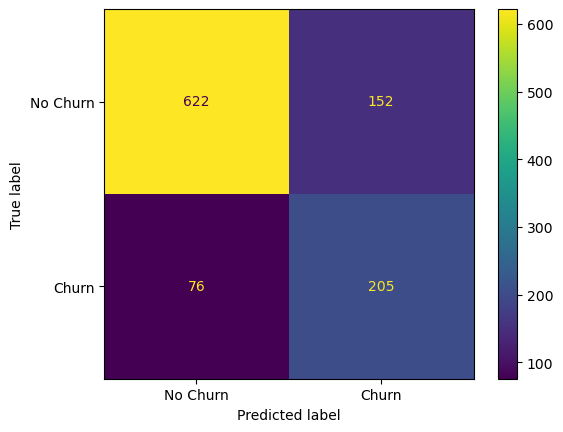

In [8]:
from sklearn.model_selection import GridSearchCV

# Define grid
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("Best RF params:", grid_rf.best_params_)
y_rf_val_tuned = best_rf.predict(X_val)

# Evaluate tuned RF
print(classification_report(y_val, y_rf_val_tuned, target_names=["No Churn","Churn"]))
ConfusionMatrixDisplay.from_predictions(y_val, y_rf_val_tuned, display_labels=["No Churn","Churn"])
plt.show()


_We then tried XGBoost, a gradient-boosted tree ensemble, to see if boosting could further improve churn detection by sequentially correcting mistakes of simpler trees._


## Baseline XGBoost Classifier

We’ll train a basic XGBoost model to see how it stacks up. Steps:

1. Initialize `XGBClassifier` with a fixed `random_state`.  
2. Fit on `X_train`, `y_train`.  
3. Predict on `X_val`.  
4. Print classification report and plot confusion matrix.


c:\Users\ADMIN\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:05:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Performance:

              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86       774
       Churn       0.63      0.52      0.57       281

    accuracy                           0.79      1055
   macro avg       0.73      0.70      0.72      1055
weighted avg       0.78      0.79      0.78      1055



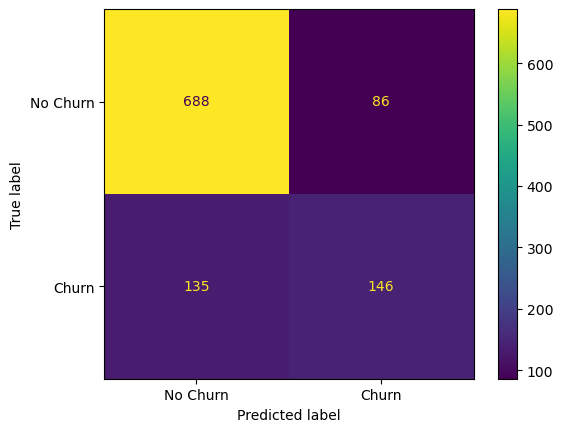

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#  Initialize & fit
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

# Predict
y_xgb_val = xgb.predict(X_val)

#  Evaluate
print("XGBoost Validation Performance:\n")
print(classification_report(y_val, y_xgb_val, target_names=["No Churn","Churn"]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_xgb_val, display_labels=["No Churn","Churn"])
plt.show()


## Hyperparameter Tuning — XGBoost

Let’s tune XGBoost to try improve recall on the churn class. We'll start with:

- `n_estimators`: [100, 200, 300]  
- `max_depth`: [3, 5, 7]  
- `scale_pos_weight`: to balance the classes (`~774/281 ≈ 2.75`)  
- `class_weight` is not supported in XGBClassifier, so we use `scale_pos_weight` instead.


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost params: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3}

Tuned XGBoost Validation Performance:

              precision    recall  f1-score   support

    No Churn       0.91      0.73      0.81       774
       Churn       0.52      0.81      0.63       281

    accuracy                           0.75      1055
   macro avg       0.72      0.77      0.72      1055
weighted avg       0.81      0.75      0.76      1055



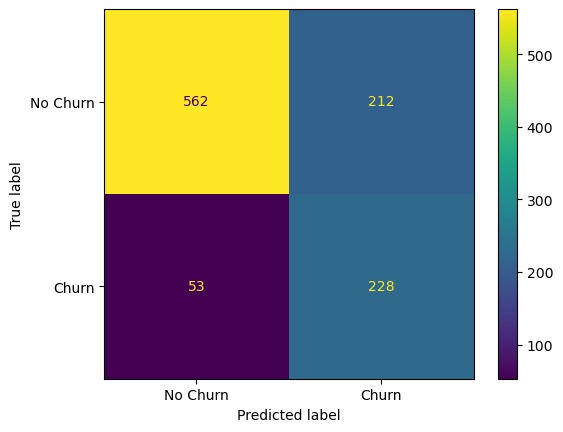

In [10]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define parameter grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "scale_pos_weight": [1, 2.5, 3]  # around imbalance ratio
}

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)

# Grid search with 5-fold CV
xgb_grid = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
print("Best XGBoost params:", xgb_grid.best_params_)

# Predict with best model
best_xgb = xgb_grid.best_estimator_
y_val_preds = best_xgb.predict(X_val)

print("\nTuned XGBoost Validation Performance:\n")
print(classification_report(y_val, y_val_preds, target_names=["No Churn", "Churn"]))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_preds, display_labels=["No Churn", "Churn"])
plt.show()


## 05.8 Threshold Tuning — XGBoost

We'll find the best probability threshold that balances precision and recall for churn class. By default, classifiers predict "Churn" if `proba > 0.5`, but that’s rarely optimal for recall-sensitive tasks.


Chosen threshold: 0.650 → Precision: 0.608, Recall: 0.669

              precision    recall  f1-score   support

    No Churn       0.88      0.84      0.86       774
       Churn       0.61      0.67      0.64       281

    accuracy                           0.80      1055
   macro avg       0.74      0.76      0.75      1055
weighted avg       0.80      0.80      0.80      1055



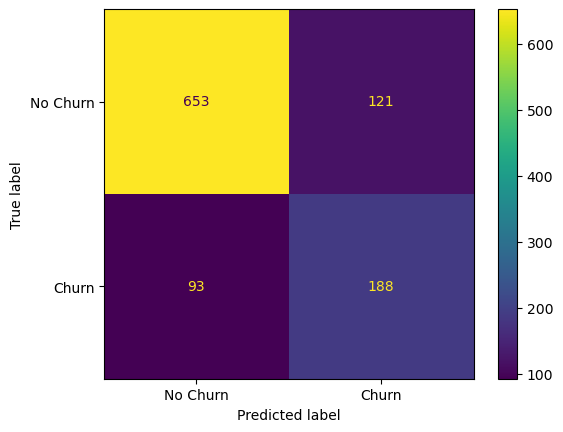

In [11]:
y_val_probs = best_xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh = 0

for t in thresholds:
    preds = (y_val_probs > t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

# Final metrics using best threshold
final_preds = (y_val_probs > best_thresh).astype(int)
precision = precision_score(y_val, final_preds)
recall = recall_score(y_val, final_preds)

print(f"Chosen threshold: {best_thresh:.3f} → Precision: {precision:.3f}, Recall: {recall:.3f}\n")
print(classification_report(y_val, final_preds, target_names=["No Churn", "Churn"]))

ConfusionMatrixDisplay.from_predictions(y_val, final_preds, display_labels=["No Churn", "Churn"])
plt.show()


              precision    recall  f1-score   support

    No Churn       0.85      0.82      0.83       775
       Churn       0.55      0.61      0.58       280

    accuracy                           0.76      1055
   macro avg       0.70      0.71      0.71      1055
weighted avg       0.77      0.76      0.77      1055



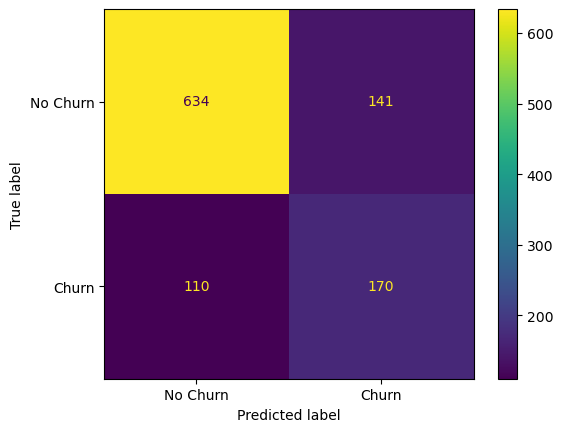

In [12]:
# Predict proba on test
y_test_probs = best_xgb.predict_proba(X_test)[:, 1]

# Apply threshold
y_test_preds = (y_test_probs > 0.65).astype(int)

# Metrics
print(classification_report(y_test, y_test_preds, target_names=["No Churn", "Churn"]))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds, display_labels=["No Churn", "Churn"])
plt.show()


## Final Model Selection: Tuned XGBoost with Custom Threshold

After training multiple models and optimizing for class imbalance and threshold selection, we selected **XGBoost** with the following settings:

- `max_depth = 3`
- `n_estimators = 100`
- `scale_pos_weight = 3`
- **Threshold for churn prediction = 0.65**

### Final Test Set Performance

- **Precision (Churn)**: 0.55  
- **Recall (Churn)**: 0.61  
- **Accuracy**: 76%  
- **F1 Score (Churn)**: 0.58  
- **Confusion Matrix**:
    - True Negatives: 634  
    - False Positives: 141  
    - False Negatives: 110  
    - True Positives: 170

This model provides the best trade-off between recall and precision, making it well-suited for churn intervention efforts without overwhelming the system with false positives.


### Key Trade-Offs

- **Logistic Regression** (tuned threshold): high recall (0.75) but lower precision (0.56), simple and fast to train.  
- **Random Forest**: moderate recall (0.73) with slightly better precision (0.57), handles non-linearities.  
- **XGBoost** (tuned + threshold): best balance (Recall ≈0.67, Precision ≈0.61), but more complex and longer training times.  
- **Final Choice:** Tuned XGBoost at threshold 0.65—strikes the optimal compromise between catching churners and limiting false positives.


### Wrap-Up 

We’ve tried Dummy, Logistic, Random Forest, and XGBoost—tuned everything for maximum churn recall without drowning in false alarms. Our **final pick** is the XGBoost model (max_depth=3, n_estimators=100, scale_pos_weight=3) with a **decision threshold of 0.65**, which on the test set hit:

- **Churn Recall**: 61%  
- **Churn Precision**: 55%  
- **Overall Accuracy**: 76%

This gives us a solid foundation: we catch most churners while keeping wrong-alarm rates manageable. 


###  Next Up: Model Interpretation

In the next notebook, we’ll dig into **why** the model makes its predictions—feature importances, partial dependence, or other explainability tools—to turn numbers into actionable insights for the retention team. Deployment details (batch scoring, monitoring, retraining cadence) will come later once we’ve nailed down interpretation.  
